# Topic Modeling

In [508]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from collections import Counter
import text_cleaning_helper_functions as hlf
from tqdm import tqdm

In [251]:
# open csv and continue cleaning
df = pd.read_csv('final_df.csv')
df.isna().any()
df.dropna(inplace=True)

# ensure single digits and single letters are excluded
df['reviews'] = df['reviews'].replace(r'\d+?', ' ', regex=True)
df['reviews'] = df['reviews'].replace(r'\s[a-z]\s', ' ', regex=True)
stop_words = stopwords.words('english')

In [252]:
# shuffle the reviews and split them into train and test groups - for classification purposes
all_reviews =  df.copy(deep=True)['reviews']
all_reviews = all_reviews.sample(frac=1).reset_index(drop=True)
train_reviews = all_reviews.copy(deep=True)[:401000]
test_reviews =  all_reviews.copy(deep=True)[401000:]

In [472]:
all_reviews

0         prossoundrangemic call claritybuttonslookconsc...
1         worked week one morning removing cable phone c...
2           thing consider noise canceling ear buds  com...
3         setting external drive almost easy took longer...
4         camera compact sleek picture taken well lit ar...
                                ...                        
501823    bracket well done robust useful one con usuall...
501824    crucial known good product general    mac    p...
501825    amazon price get blindfolded great prop ipad v...
501826    main purpose type speaker provide hidden sourc...
501827           light bright looking use take picture like
Name: reviews, Length: 501828, dtype: object

In [253]:
# separate df for join the topic components on
reviews_concat = all_reviews.copy(deep=True)

In [254]:
# sanity check
print(len(train_reviews))
print(len(test_reviews))
print(len(all_reviews))

401000
100828
501828


In [255]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# LDA

In [33]:
def print_topics(model, features, n):
    ''' This model prints and saves the 'N' most important words from every topic '''
    # make sure the features is in a numpy array to use .argsort
    if type(features) == list:
        features = np.array(features)
    
    # save the n most important words for each topic
    components = model.components_ 
    top_n = [features[component.argsort()][-n-1:] for component in components]
    
    # print the top words for every each topic
    for i in range(len(top_n)):
        print(f"Topic {i+1} most important words: {top_n[i]}")
    return top_n

In [41]:
# vectorize the data and get check what the top words
tf_idf_vectorize = TfidfVectorizer(max_df=0.5, max_features=10000,
                                  min_df=10, use_idf=True)

tf_idf = tf_idf_vectorize.fit_transform(all_reviews)

# extract feature name and run LDA model (there are 14~ type of products in amazon's electronic department)
features = tf_idf_vectorize.get_feature_names()
LDA = LatentDirichletAllocation(n_components=14, random_state=1234,
                                n_jobs=-1, verbose=1).fit(tf_idf)

LDA_topics = hlf.print_topics(LDA, features , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['reception' 'radio' 'screw' 'work' 'cable' 'wall' 'channel' 'signal'
 'mount' 'tv' 'antenna']
Topic 2 most important words: ['cord' 'charging' 'phone' 'plug' 'work' 'usb' 'cable' 'power' 'charger'
 'charge' 'battery']
Topic 3 most important words: ['hand' 'feel' 'like' 'battery' 'use' 'work' 'logitech' 'button' 'key'
 'keyboard' 'mouse']
Topic 4 most important words: ['memory' 'speed' 'data' 'file' 'hard' 'computer' 'work' 'gb' 'usb' 'card'
 'drive']
Topic 5 most important words: ['tablet' 'stand' 'hold' 'strap' 'like' 'kindle' 'bag' 'ipad' 'fit'
 'cover' 'case']
Topic 6 most important words: ['good' 'cover' 'work' 'dust' 'like' 'case' 'plastic' 'product' 'bubble'
 'pro

In [446]:
# add the topics to next to the reviews
LDA_topics = pd.DataFrame(LDA.transform(tf_idf))

# get the highest value from every row
max_val = LDA_topics.max(axis=1)

topic_names = [f"topic_{c}" for c in LDA_topics.columns]
LDA_topics.columns = topic_names

reviews_with_topics = pd.concat([reviews_concat, doc_topics], axis=1)
reviews_with_topics.head()

,reviews,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,prossoundrangemic call claritybuttonslookconsc...,0.011433,0.011433,0.011434,0.058429,0.011434,0.011433,0.815802,0.011433,0.011433,0.011433,0.011434,0.011434,0.011433
1,worked week one morning removing cable phone c...,0.017072,0.017072,0.017072,0.017072,0.091267,0.017072,0.017072,0.017072,0.720944,0.017071,0.017072,0.017072,0.017072
2,thing consider noise canceling ear buds com...,0.016927,0.016927,0.016930,0.016927,0.016927,0.103957,0.016927,0.016927,0.344292,0.016928,0.016927,0.382476,0.016927
3,setting external drive almost easy took longer...,0.012028,0.023043,0.337049,0.012028,0.345856,0.012028,0.012029,0.012028,0.012028,0.012028,0.012029,0.012028,0.185797
4,camera compact sleek picture taken well lit ar...,0.012533,0.012533,0.012533,0.012533,0.625482,0.012533,0.012533,0.012533,0.012533,0.012533,0.236656,0.012533,0.012533


In [445]:
reviews_with_topics.reviews[0]

'audiophile wanted decent set earbuds    replace ipod headphone finally gave ghost interest expensive set want ear style headphone based review price went overall happy complaint dismissed simply looking price pro inexpensive decent sound bass clarity standard ipod headphone con bigger earbuds right angle    mm connector may prefer black color overall happy price would recommend anybody looking inexpensive set earbuds'

# LDA Bigarm

In [43]:
# tfidf bigrams
tf_idf_n2_vec = TfidfVectorizer(max_df=0.5, max_features=10000,
                                min_df=10, use_idf=True, 
                                ngram_range=(1, 2))

# extract features name and run the model
tf_idf_n2 = tf_idf_n2_vec.fit_transform(all_reviews)
features_n2 = tf_idf_n2_vec.get_feature_names()

LDA_n2 = LatentDirichletAllocation(n_components=14, random_state=1234,
                                   n_jobs=-1, verbose=1).fit(tf_idf_n2)

LDA_n2_topics = hlf.print_topics(LDA_n2, features_n2 , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['item' 'use' 'charge' 'bought' 'buy' 'easy' 'quality' 'work great'
 'recommend' 'product' 'good' 'great' 'work' 'price' 'battery']
Topic 2 most important words: ['problem' 'port' 'wireless' 'file' 'support' 'network' 'driver' 'device'
 'software' 'computer' 'usb' 'work' 'drive' 'router' 'window']
Topic 3 most important words: ['good' 'work' 'product' 'touch' 'stylus' 'use' 'like' 'ipad' 'bubble'
 'screen protector' 'tablet' 'key' 'protector' 'keyboard' 'screen']
Topic 4 most important words: ['netflix' 'device' 'ray' 'play' 'monitor' 'movie' 'picture' 'work'
 'cable' 'video' 'hdmi' 'dvd' 'player' 'remote' 'tv']
Topic 5 most important words: ['like' 'great' 'noise' 'pair

# Gensim LDA

In [256]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize 

In [257]:
# tokenize reviews
tokened_reviews = [word_tokenize(i) for i in all_reviews]

# create dictionary and filter out words that appear in less than 10 documents or in more than 50% of documents 
dictionary = gensim.corpora.Dictionary(tokened_reviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=8000)

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in tokened_reviews]

gensim_LDA = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, 
                                       passes=3, workers=4, per_word_topics=True,
                                       random_state=123)

Topic 1: 0.047*"camera" + 0.022*"lens" + 0.009*"canon" + 0.009*"picture" + 0.009*"light" + 0.009*"good" + 0.008*"image"
Topic 2: 0.020*"keyboard" + 0.015*"unit" + 0.014*"key" + 0.009*"time" + 0.008*"button" + 0.008*"one" + 0.008*"gps"
Topic 3: 0.035*"sound" + 0.019*"speaker" + 0.016*"headphone" + 0.013*"good" + 0.013*"quality" + 0.012*"ear" + 0.008*"like"
Topic 4: 0.036*"cable" + 0.024*"usb" + 0.020*"work" + 0.018*"power" + 0.014*"adapter" + 0.013*"port" + 0.013*"one"
Topic 5: 0.018*"drive" + 0.017*"one" + 0.013*"product" + 0.011*"time" + 0.011*"would" + 0.010*"work" + 0.010*"amazon"
Topic 6: 0.053*"battery" + 0.026*"mouse" + 0.016*"charge" + 0.014*"use" + 0.013*"work" + 0.012*"one" + 0.011*"button"
Topic 7: 0.032*"card" + 0.022*"video" + 0.012*"radio" + 0.011*"camera" + 0.011*"use" + 0.011*"player" + 0.010*"file"
Topic 8: 0.029*"case" + 0.011*"like" + 0.011*"screen" + 0.011*"ipad" + 0.011*"fit" + 0.010*"one" + 0.010*"cover"
Topic 9: 0.013*"router" + 0.011*"device" + 0.010*"window" + 0

## View the composition of different topics in a formatted way

In [582]:
list_of_topics = gensim_LDA.show_topics(formatted=False)

Topic_1 = list_of_topics[0][1]
Topic_1_df = pd.DataFrame(Topic_1)
Topic_1_df = Topic_1_df.set_index(0).T
Topic_1_df.rename(index={1: 'Topic 1'})

,camera,lens,canon,picture,light,good,image,quality,use,get
Topic 5,0.046918,0.022409,0.009296,0.009264,0.009034,0.008734,0.008158,0.007979,0.007902,0.006892


In [581]:
Topic_2 = list_of_topics[1][1]
Topic_2_df = pd.DataFrame(Topic_2)
Topic_2_df = Topic_2_df.set_index(0).T
Topic_2_df.rename(index={1: 'Topic 2'})

,keyboard,unit,key,time,button,one,gps,use,get,device
Topic 8,0.019946,0.015426,0.013899,0.009323,0.008466,0.008017,0.007873,0.007678,0.007509,0.007328


In [580]:
Topic_3 = list_of_topics[2][1]
Topic_3_df = pd.DataFrame(Topic_3)
Topic_3_df = Topic_3_df.set_index(0).T
Topic_3_df.rename(index={1: 'Topic 3'})

,sound,speaker,headphone,good,quality,ear,like,music,volume,bass
Topic 6,0.0346,0.018537,0.015657,0.012802,0.012658,0.01221,0.008361,0.007877,0.007749,0.00759


In [329]:
def create_word_clouds(model, n=2, j=5, save=0, start=0, stop=None):
    """
    create_word_clouds(model, n, j, save, start, stop):
    Params:
        model: gensim LDA model object
        n: number of subplots in a column  (default=2)
        j: number of subplots in a row (default=5)
        save: save the figure (optional, default=0)
        start: from what number topic you wish to create the subplot (optional, default=0)
        stop: stop the subplot at a certain topic (optional, default=None)
        
    Returns:
        Word cloud image for every topic LDA created
    """
    # create color list
    colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]
    
    # instantiate cloud
    cloud = WordCloud(background_color='white',
                      width=1028,
                      height=726,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[start],
                      prefer_horizontal=1.0)
    
    # extract topics
    topics = model.show_topics(formatted=False)
    
    # create subplots 
    fig, axes = plt.subplots(n, j, figsize=(10,10), sharex=True, sharey=True)
    
    for ax in axes.flatten():
        fig.add_subplot(ax)
        topic_words = dict(topics[start][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(start+1), fontdict=dict(size=16))
        # hide axis
        plt.gca().axis('off')
        start += 1
        if start == stop:
            break
        
    plt.subplots_adjust(wspace=0, hspace=0)
    # hide axis
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if save:
        plt.savefig(f'topics_cloud{start}.png')
    plt.show()

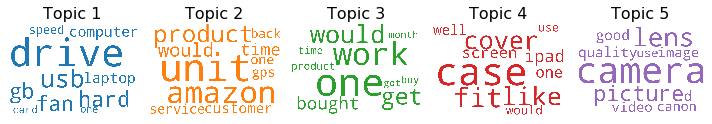

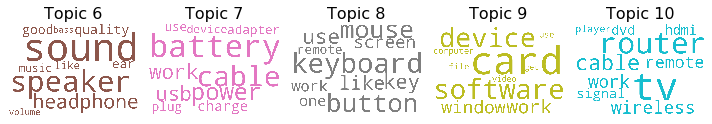

In [242]:
# plot and save the different topics. each word is sized by how many time they repeat
for start in [0, 5]:
    hlf.create_word_clouds(gensim_LDA, n=1, j=5, save=0, start=start)

In [590]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [592]:
bigrams =  [bigram_mod[review] for review in tqdm(all_reviews)]


  1%|▌                                                                          | 3723/501828 [00:07<17:33, 472.66it/s]


  1%|█                                                                          | 7394/501828 [00:16<22:38, 364.06it/s]


  2%|█▌                                                                        | 10244/501828 [00:24<23:24, 350.00it/s]


  3%|██                                                                        | 13766/501828 [00:32<16:20, 497.76it/s]


  3%|██▌                                                                       | 17233/501828 [00:40<29:15, 276.11it/s]


  4%|███                                                                       | 20785/501828 [00:49<16:48, 476.92it/s]


  5%|███▌                                                                      | 24388/501828 [00:58<18:11, 437.42it/s]


  5%|████                                                                      | 27413/501828 [01:06<14:08, 559.45it/s]


  6%|████▌                                                                     | 30897/501828 [01:15<19:51, 395.39it/s]


  7%|█████                                                                     | 34104/501828 [01:24<21:35, 361.05it/s]


  7%|█████▌                                                                    | 37381/501828 [01:33<16:09, 479.10it/s]


  8%|█████▉                                                                    | 40671/501828 [01:42<26:49, 286.55it/s]


  9%|██████▍                                                                   | 43995/501828 [01:50<16:14, 469.89it/s]


  9%|██████▉                                                                   | 47207/501828 [01:59<27:13, 278.29it/s]


 10%|███████▍                                                                  | 50268/501828 [02:08<17:43, 424.50it/s]


 11%|███████▉                                                                  | 53489/501828 [02:17<19:55, 374.87it/s]


 11%|████████▎                                                                 | 56745/501828 [02:25<18:18, 405.22it/s]


 12%|████████▊                                                                 | 59482/501828 [02:34<20:42, 355.98it/s]


 13%|█████████▎                                                                | 62900/501828 [02:42<17:13, 424.55it/s]


 13%|█████████▋                                                                | 65830/501828 [02:51<17:53, 406.18it/s]


 14%|██████████▏                                                               | 68913/501828 [03:00<20:17, 355.56it/s]


 14%|██████████▋                                                               | 72398/501828 [03:08<16:50, 424.89it/s]


 15%|███████████▏                                                              | 75743/501828 [03:17<14:48, 479.80it/s]


 16%|███████████▌                                                              | 78784/501828 [03:26<15:00, 469.93it/s]


 16%|████████████▏                                                             | 82269/501828 [03:34<15:57, 438.10it/s]


 17%|████████████▌                                                             | 85455/501828 [03:42<14:01, 494.96it/s]


 18%|█████████████                                                             | 88762/501828 [03:51<16:39, 413.30it/s]


 18%|█████████████▌                                                            | 92314/501828 [04:00<12:52, 530.35it/s]


 19%|██████████████▏                                                           | 95999/501828 [04:09<18:39, 362.37it/s]


 20%|██████████████▋                                                           | 99545/501828 [04:17<14:44, 454.68it/s]


 21%|██████████████▉                                                          | 102881/501828 [04:26<18:08, 366.56it/s]


 21%|███████████████▍                                                         | 106340/501828 [04:35<13:51, 475.61it/s]


 22%|███████████████▉                                                         | 109571/501828 [04:44<18:26, 354.39it/s]


 23%|████████████████▍                                                        | 112945/501828 [04:52<13:19, 486.70it/s]


 23%|████████████████▉                                                        | 116486/501828 [05:00<13:54, 461.74it/s]


 24%|█████████████████▍                                                       | 120008/501828 [05:08<15:57, 398.80it/s]


 25%|█████████████████▉                                                       | 123595/501828 [05:16<14:24, 437.75it/s]


 25%|██████████████████▍                                                      | 126930/501828 [05:25<17:30, 356.98it/s]


 26%|██████████████████▉                                                      | 130285/501828 [05:33<19:39, 314.98it/s]


 27%|███████████████████▎                                                     | 133180/501828 [05:42<11:59, 512.72it/s]


 27%|███████████████████▊                                                     | 136496/501828 [05:51<13:21, 455.63it/s]


 28%|████████████████████▎                                                    | 139884/501828 [05:59<14:22, 419.60it/s]


 28%|████████████████████▊                                                    | 142906/501828 [06:08<17:39, 338.82it/s]


 29%|█████████████████████▎                                                   | 146419/501828 [06:16<13:02, 454.17it/s]


 30%|█████████████████████▊                                                   | 149686/501828 [06:24<17:42, 331.46it/s]


 30%|██████████████████████▎                                                  | 153056/501828 [06:33<13:05, 444.08it/s]


 31%|██████████████████████▋                                                  | 156232/501828 [06:41<17:13, 334.54it/s]


 32%|███████████████████████▏                                                 | 159312/501828 [06:50<15:37, 365.26it/s]


 32%|███████████████████████▋                                                 | 162761/501828 [06:59<12:30, 451.72it/s]


 33%|████████████████████████                                                 | 165721/501828 [07:08<20:47, 269.34it/s]


 34%|████████████████████████▌                                                | 169082/501828 [07:48<13:53, 399.25it/s]


 34%|█████████████████████████                                                | 172186/501828 [07:56<09:54, 554.92it/s]


 35%|█████████████████████████▌                                               | 175824/501828 [08:05<13:47, 394.02it/s]


 36%|██████████████████████████                                               | 179412/501828 [08:13<11:24, 470.74it/s]


 36%|██████████████████████████▌                                              | 182665/501828 [08:22<12:01, 442.48it/s]


 37%|███████████████████████████                                              | 186011/501828 [08:30<13:34, 387.73it/s]


 38%|███████████████████████████▌                                             | 189178/501828 [08:39<15:34, 334.47it/s]


 38%|████████████████████████████                                             | 192649/501828 [08:48<11:30, 447.94it/s]


 39%|████████████████████████████▌                                            | 195976/501828 [08:56<13:43, 371.45it/s]


 40%|████████████████████████████▉                                            | 199294/501828 [09:05<14:48, 340.49it/s]


 40%|█████████████████████████████▍                                           | 202631/501828 [09:14<14:10, 351.66it/s]


 41%|█████████████████████████████▉                                           | 205690/501828 [09:22<16:14, 303.88it/s]


 42%|██████████████████████████████▍                                          | 208838/501828 [09:31<11:51, 411.83it/s]


 42%|██████████████████████████████▉                                          | 212405/501828 [09:39<13:17, 363.00it/s]


 43%|███████████████████████████████▎                                         | 215462/501828 [09:47<12:35, 379.06it/s]


 44%|███████████████████████████████▊                                         | 218882/501828 [09:56<14:02, 335.98it/s]


 44%|████████████████████████████████▎                                        | 222325/501828 [10:04<11:14, 414.13it/s]


 45%|████████████████████████████████▊                                        | 225722/501828 [10:12<10:03, 457.27it/s]


 46%|█████████████████████████████████▎                                       | 228963/501828 [10:21<08:07, 560.21it/s]


 46%|█████████████████████████████████▉                                       | 233249/501828 [10:30<10:54, 410.62it/s]


 47%|██████████████████████████████████▌                                      | 237534/501828 [10:38<11:00, 400.03it/s]


 48%|███████████████████████████████████                                      | 241100/501828 [10:46<12:08, 357.88it/s]


 49%|███████████████████████████████████▋                                     | 245210/501828 [10:55<06:47, 630.35it/s]


 50%|████████████████████████████████████▏                                    | 248801/501828 [11:03<08:03, 523.19it/s]


 50%|████████████████████████████████████▋                                    | 252106/501828 [11:11<08:41, 478.46it/s]


 51%|█████████████████████████████████████▏                                   | 255970/501828 [11:19<08:57, 457.38it/s]


 52%|█████████████████████████████████████▋                                   | 259254/501828 [11:28<09:26, 427.84it/s]


 52%|██████████████████████████████████████▏                                  | 262560/501828 [11:36<08:23, 475.64it/s]


 53%|██████████████████████████████████████▋                                  | 265873/501828 [11:44<10:09, 387.39it/s]


 54%|███████████████████████████████████████▏                                 | 269251/501828 [11:52<12:04, 320.96it/s]


 54%|███████████████████████████████████████▋                                 | 272620/501828 [12:01<08:55, 427.91it/s]


 55%|████████████████████████████████████████▏                                | 276086/501828 [12:09<06:31, 576.81it/s]


 56%|████████████████████████████████████████▋                                | 279669/501828 [12:18<17:33, 210.80it/s]


 56%|█████████████████████████████████████████▏                               | 283381/501828 [12:25<08:59, 404.75it/s]


 57%|█████████████████████████████████████████▋                               | 286745/501828 [12:33<07:14, 494.79it/s]


 58%|██████████████████████████████████████████▏                              | 290175/501828 [12:42<07:49, 450.60it/s]


 58%|██████████████████████████████████████████▋                              | 293360/501828 [12:50<12:58, 267.88it/s]


 59%|███████████████████████████████████████████▏                             | 296762/501828 [12:58<08:48, 388.14it/s]


 60%|███████████████████████████████████████████▋                             | 300339/501828 [13:07<08:46, 383.00it/s]


 61%|████████████████████████████████████████████▏                            | 304028/501828 [13:15<06:09, 535.43it/s]


 61%|████████████████████████████████████████████▋                            | 307562/501828 [13:23<06:47, 476.57it/s]


 62%|█████████████████████████████████████████████▏                           | 310985/501828 [13:32<09:19, 341.38it/s]


 63%|█████████████████████████████████████████████▊                           | 314839/501828 [13:39<05:26, 573.54it/s]


 64%|██████████████████████████████████████████████▍                          | 318918/501828 [13:47<05:31, 552.54it/s]


 64%|██████████████████████████████████████████████▉                          | 322393/501828 [13:56<12:35, 237.55it/s]


 65%|███████████████████████████████████████████████▍                         | 325886/501828 [14:04<06:25, 456.06it/s]


 66%|███████████████████████████████████████████████▉                         | 329160/501828 [14:12<05:27, 526.97it/s]


 66%|████████████████████████████████████████████████▍                        | 332669/501828 [14:20<07:53, 357.59it/s]


 67%|████████████████████████████████████████████████▉                        | 336018/501828 [14:29<08:03, 342.99it/s]


 68%|█████████████████████████████████████████████████▎                       | 339353/501828 [14:37<10:16, 263.54it/s]


 68%|█████████████████████████████████████████████████▉                       | 342980/501828 [14:45<06:46, 390.59it/s]


 69%|██████████████████████████████████████████████████▍                      | 346490/501828 [14:53<05:04, 510.52it/s]


 70%|██████████████████████████████████████████████████▉                      | 350184/501828 [15:01<06:17, 401.95it/s]


 70%|███████████████████████████████████████████████████▍                     | 353536/501828 [15:09<06:18, 391.62it/s]


 71%|███████████████████████████████████████████████████▉                     | 357165/501828 [15:18<06:00, 401.51it/s]


 72%|████████████████████████████████████████████████████▍                    | 360741/501828 [15:26<05:06, 459.84it/s]


 73%|████████████████████████████████████████████████████▉                    | 364212/501828 [15:34<05:49, 393.62it/s]


 73%|█████████████████████████████████████████████████████▍                   | 367735/501828 [15:42<06:27, 346.16it/s]


 74%|█████████████████████████████████████████████████████▉                   | 370923/501828 [15:50<07:10, 303.89it/s]


 74%|██████████████████████████████████████████████████████▎                  | 373680/501828 [15:58<07:00, 304.87it/s]


 75%|██████████████████████████████████████████████████████▊                  | 376622/501828 [16:06<06:58, 299.52it/s]


 76%|███████████████████████████████████████████████████████▎                 | 379857/501828 [16:14<06:16, 324.05it/s]


 76%|███████████████████████████████████████████████████████▋                 | 382942/501828 [16:22<05:08, 384.98it/s]


 77%|████████████████████████████████████████████████████████▏                | 385880/501828 [16:30<05:02, 383.37it/s]


 77%|████████████████████████████████████████████████████████▌                | 388674/501828 [16:38<04:44, 397.12it/s]


 78%|████████████████████████████████████████████████████████▉                | 391711/501828 [16:45<04:06, 447.32it/s]


 79%|█████████████████████████████████████████████████████████▍               | 394780/501828 [16:53<04:23, 405.81it/s]


 79%|█████████████████████████████████████████████████████████▊               | 397610/501828 [17:01<04:30, 385.98it/s]


 80%|██████████████████████████████████████████████████████████▎              | 400452/501828 [17:09<04:31, 374.04it/s]


 80%|██████████████████████████████████████████████████████████▋              | 403411/501828 [17:17<04:42, 347.77it/s]


 81%|███████████████████████████████████████████████████████████              | 406372/501828 [17:25<04:04, 390.48it/s]


 82%|███████████████████████████████████████████████████████████▌             | 409377/501828 [17:33<04:04, 378.38it/s]


 82%|███████████████████████████████████████████████████████████▉             | 412361/501828 [17:41<03:55, 379.73it/s]


 83%|████████████████████████████████████████████████████████████▍            | 415297/501828 [17:49<04:18, 334.32it/s]


 83%|████████████████████████████████████████████████████████████▊            | 418404/501828 [17:57<02:52, 482.99it/s]


 84%|█████████████████████████████████████████████████████████████▎           | 421514/501828 [18:05<03:37, 369.93it/s]


 85%|█████████████████████████████████████████████████████████████▋           | 424461/501828 [18:12<03:37, 356.23it/s]


 85%|██████████████████████████████████████████████████████████████▏          | 427438/501828 [18:21<03:53, 319.11it/s]


 86%|██████████████████████████████████████████████████████████████▌          | 430391/501828 [18:28<02:55, 405.97it/s]


 86%|███████████████████████████████████████████████████████████████          | 433316/501828 [18:36<03:26, 332.32it/s]


 87%|███████████████████████████████████████████████████████████████▍         | 436384/501828 [18:44<03:06, 351.72it/s]


 88%|███████████████████████████████████████████████████████████████▉         | 439713/501828 [18:52<02:44, 377.93it/s]


 88%|████████████████████████████████████████████████████████████████▍        | 442657/501828 [19:00<02:59, 329.38it/s]


 89%|████████████████████████████████████████████████████████████████▊        | 445523/501828 [19:08<02:26, 385.50it/s]


 89%|█████████████████████████████████████████████████████████████████▏       | 448447/501828 [19:15<02:20, 379.43it/s]


 90%|█████████████████████████████████████████████████████████████████▋       | 451353/501828 [19:23<02:25, 347.44it/s]


 91%|██████████████████████████████████████████████████████████████████       | 454173/501828 [19:31<02:02, 390.23it/s]


 91%|██████████████████████████████████████████████████████████████████▍      | 456910/501828 [19:39<02:08, 350.65it/s]


 92%|██████████████████████████████████████████████████████████████████▉      | 459884/501828 [19:47<02:22, 295.03it/s]


 92%|███████████████████████████████████████████████████████████████████▎     | 462815/501828 [19:55<01:42, 379.84it/s]


 93%|███████████████████████████████████████████████████████████████████▊     | 465791/501828 [20:03<01:53, 317.25it/s]


 93%|████████████████████████████████████████████████████████████████████▏    | 468836/501828 [20:11<01:36, 341.45it/s]


 94%|████████████████████████████████████████████████████████████████████▋    | 471822/501828 [20:19<01:14, 402.44it/s]


 95%|█████████████████████████████████████████████████████████████████████    | 474753/501828 [20:27<01:06, 404.70it/s]


 95%|█████████████████████████████████████████████████████████████████████▍   | 477621/501828 [20:35<01:10, 345.19it/s]


 96%|█████████████████████████████████████████████████████████████████████▉   | 480651/501828 [20:42<00:46, 457.87it/s]


 96%|██████████████████████████████████████████████████████████████████████▎  | 483664/501828 [20:50<00:46, 391.25it/s]


 97%|██████████████████████████████████████████████████████████████████████▊  | 486564/501828 [20:59<01:03, 240.43it/s]


 98%|███████████████████████████████████████████████████████████████████████▏ | 489540/501828 [21:06<00:30, 400.36it/s]


 98%|███████████████████████████████████████████████████████████████████████▋ | 492553/501828 [21:14<00:22, 414.69it/s]


 99%|████████████████████████████████████████████████████████████████████████ | 495703/501828 [21:22<00:13, 452.42it/s]


 99%|████████████████████████████████████████████████████████████████████████▌| 498669/501828 [21:30<00:07, 396.68it/s]


100%|████████████████████████████████████████████████████████████████████████▉| 501656/501828 [21:38<00:00, 349.02it/s]


100%|█████████████████████████████████████████████████████████████████████████| 501828/501828 [21:38<00:00, 386.44it/s]

In [596]:
# Create Dictionary
bi_2word = corpora.Dictionary(tokened_reviews)

# Term Document Frequency
corpus2 = [bi_2word.doc2bow(text) for text in tokened_reviews]

In [ ]:

Data Is Plural — Structured Archive
100%
nature
4 of 47
Context:
CE3 Nature-spotting.
 

http://www.inaturalist.org/pages/about
http://www.inaturalist.org/observations/2656845
http://inaturalist.tumblr.com/post/133980888898/2-million-observations
http://www.inaturalist.org/pages/api+reference
http://www.inaturalist.org/observations/export
To enable screen reader support, press Ctrl+Alt+Z To learn about keyboard shortcuts, press Ctrl+slash
 
 
 		



Anonymous Lemur has joined the document.